References: 

Ström & Kartasalo, 2020 

Rohit Singh's Notebook: https://www.kaggle.com/rohitsingh9990/panda-eda-better-visualization-simple-baseline

Prostate Cancer (PCa) Grade assessment.

We are provided with a labelled training set of 10,616 Whole Slide Images of prostate tissue biopsies. These tissue samples are examined by a pathologist and scored according to the Gleason grading system. The Gleason Score directly leads to the ISUP grade as per figure 1. The training set for this challenge is the most extensive multi-center dataset on Gleason grading available.

Biopsies recieve their Gleason grade according to the architectural growth patterns of the tumor (Fig. 1). As shown in Fig. 1, the patterns present in a single biopsy are used to form a Gleason score, e.g. 4 + 3 = 7. 

To simplify slightly, in the case of multiple different Gleason patterns being present, the score is composed of the most frequently occurring pattern and the second most frequent pattern in the biopsy, as judged by the pathologist. The minority pattern must account for at least 5% of the total area to be included, e.g. if pattern 3 is less than 5%, the Gleason score 4 + 3 will instead be 4 + 4. Further, the highest grade should always be part of the score. For example, a biopsy that contains 60% Gleason 4, 37% Gleason 3 and 3% Gleason 5 should get a score of 4 + 5 = 9. For details see (Epstein, 2016).

There is a risk of missing cancers, and a risk of overgrading resulting in unnecessary treatment. The system suffers from significant inter-observer variability, while in some countries there is a lack of qaulified pathologists. 

Deep Learning systems have shown promise in accurately grading PCa. These systems were not, until this challenge tested with multi-center datasets at scale.

Submissions will be scored based on their performance in predicting an ISUP grade for a hidden test set graded by expert pathologists. The quadratic weighted kappa is used to score submissions. A score of 1 represents a perfect submission with no errors on the test set, while 0 represents a performance no better than chance. The weighted kappa penalises incorrect predictions more the further they lie from the correct ISUP value.

Figure 1.
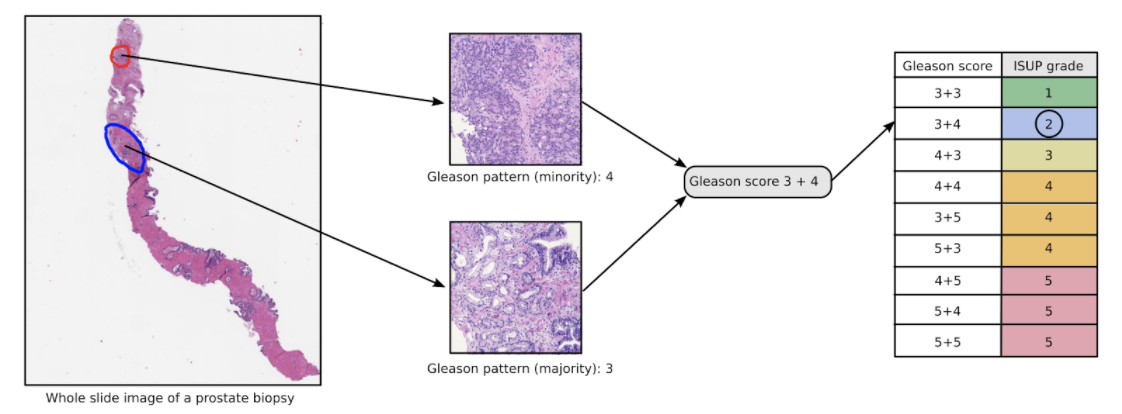

 **Exploratory Data Analysis** (Rohit Singh's Notebook listed in references was helpful for several aspects of this.)
 


In [ ]:
# Importing useful libraries. 

import numpy as np 
import pandas as pd 
import os
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#set directory
MAIN_DIR = '../input/prostate-cancer-grade-assessment'
# load data
train = pd.read_csv(os.path.join(MAIN_DIR, 'train.csv')).set_index('image_id')
test = pd.read_csv(os.path.join(MAIN_DIR, 'test.csv')).set_index('image_id')


In [ ]:
display(train.head())
print("Shape of training data :", train.shape)
print("unique data provider :", len(train.data_provider.unique()))
print("unique isup_grades (Target Variable) :", len(train.isup_grade.unique()))
print("unique gleason_scores :", len(train.gleason_score.unique()))

We see above the first 5 rows and header row of our data.. We also see our training data has shape 10616 x 3. 10616 image ids (images can be loaded from this unique id) and the corresponding data provider (karoliska or radboud), ISUP grade, and Gleason Score which directly leads to the ISUP grade as per Figure 1.

In [ ]:
display(test.head())
print('Shape of test data: ', test.shape)
print('unique data provider: ', len(test.data_provider.unique()))

We see here that within the test data we are provided with image id and data_provider. We have the same two unique data providers. As mentioned in the challenge overview this is a truncated version of the test file, full versions are available to notebooks upon submission. 

Let us now dig into the data further to check distribution of ISUP grades and Gleason Patterns, both generally and comparing across providers. We will also check that Gleason Patterns and ISUP Grades match for each training example.

In [ ]:
# We now define a function that will be useful to us several times. Thanks to Rohit Singh's notebook.
def plot_count(df, feature, title='', size=2):
    f, ax = plt.subplots(1,1, figsize=(4*size,3*size))
    total = float(len(df))
    sns.countplot(df[feature],order = df[feature].value_counts().index, palette='deep')
    plt.title(title)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 9,
                '{:1.2f}%'.format(100*height/total),
                ha="center") 
    plt.show()

In [ ]:
plot_count(df=train, feature='data_provider', title = 'Data provider - count and percentage share')

In [ ]:
plot_count(df=train, feature='isup_grade', title = 'ISUP grade - count and percentage share')

We see that our training data is close enough to being evenly split between our two data providers. We see that over 25% of our data is benign, (ISUP grade 0), while another 25% is ISUP grade 1, the other 4 ISUP grades are present in our data at a rate in the range 11.5% to 12.7%. 

In [ ]:
plot_count(df=train, feature='gleason_score', title = 'Gleason Score - count and percentage share', size=3)

We see in the above chart that there are comparatively few training examples for some of the most severe Gleason Patterns. The only category involving Gleason pattern 5 which is present in the traning data at a rate of more than 2.5% is 4+5. Let us compute the likelihood that the Gleason Score is 4+5 given that 5 is one of the scores. This may serve as a useful sanity check on model predictions.

In [ ]:
print(len(train[train['gleason_score'] == '4+5'])/(len(train[train['gleason_score'] == '4+5'])+len(train[train['gleason_score'] == '5+4'])+len(train[train['gleason_score'] == '5+5'])+len(train[train['gleason_score'] == '3+5'])+len(train[train['gleason_score'] == '5+3'])))

We also see that benign slides have two different lables 0+0 or negative, presumably this is due to variation in labelling by data provider. The code below confirms this. Radboud labels benign examples as 'negative' label while karolinska uses '0+0'.

In [ ]:
print(len(train[(train.data_provider == 'radboud') & (train.gleason_score == '0+0')]))
print(len(train[(train.data_provider == 'radboud') & (train.gleason_score == 'negative')]))
print(len(train[(train.data_provider == 'karolinska') & (train.gleason_score == '0+0')]))
print(len(train[(train.data_provider == 'karolinska') & (train.gleason_score == 'negative')]))

Let us now check how the distibrution of Gleason score's vary by provider. 

In [ ]:
def plot_relative_distribution(df, feature, hue, title='', size=2):
    f, ax = plt.subplots(1,1, figsize=(4*size,3*size))
    total = float(len(df))
    sns.countplot(x=feature, hue=hue, data=df, palette='deep')
    plt.title(title)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(100*height/total),
                ha="center") 
    plt.show()

In [ ]:
plot_relative_distribution(df=train, feature='gleason_score', hue='data_provider', title = 'relative distribution of Gleason score by Data provider', size=3.5)

This chart confirms what we checked earlier with regards the differing labels of benign examples across our two data providers. We also see more than twice as many 3+3 scores from karoliska than radboud. While the opposite is true for Gleason score 4+3. More of our severe cases (scores with 5 as minority or majority pattern) come from radboud rather than karolinska. Generally the cases from karolinska are skewed towards the less severe end of the scale compared to radboud. Let us now compare the relative distribution of ISUP grade by data provider.

In [ ]:
plot_relative_distribution(df=train, feature='isup_grade', hue='data_provider', title = 'relative distribution of ISUP grade by data_provider', size=2)

We see karaolinska provides more of the training examples with ISUP grade 0 or 1, while radboud provides more of the training examples with ISUP grade 3,4 or 5.

Let us now check to ensure that Gleason patterns are mapped to ISUP grades as per figure 1.

In [ ]:
plot_relative_distribution(df=train, feature='gleason_score', hue='isup_grade', title = 'relative distribution of Gleason score by ISUP grade', size=3)

We see that ~1 training example with Gleason Pattern 4+3 is mapped to an unexpected ISUP grade. We shall find now find the image id for this suspicious case, and also ensure there are no other suspicious cases.

In [ ]:
print(train[(train.gleason_score == '0+0') & (train.isup_grade != 0)])
print(train[(train.gleason_score == '4+4') & (train.isup_grade != 4)])
print(train[(train.gleason_score == '3+3') & (train.isup_grade != 1)])
print(train[(train.gleason_score == '4+3') & (train.isup_grade != 3)])
print(train[(train.gleason_score == 'negative') & (train.isup_grade != 0)])
print(train[(train.gleason_score == '4+5') & (train.isup_grade != 5)])
print(train[(train.gleason_score == '3+4') & (train.isup_grade != 2)])
print(train[(train.gleason_score == '5+4') & (train.isup_grade != 5)])
print(train[(train.gleason_score == '5+5') & (train.isup_grade != 5)])
print(train[(train.gleason_score == '5+3') & (train.isup_grade != 4)])
print(train[(train.gleason_score == '3+5') & (train.isup_grade != 4)])

There is just one suspicious case which we saw on the plot. A training example from karolinska with Gleason score 4+3 but ISUP grade of 2. We will probably remove this example unless there is a very obvious mis-labelling we can correct.

Ok so that is the end of our exploratory data analysis, we have isolated a mis-labelled example, discovered two differing labels for benign cases and gained an understanding about how our examples break down by data provider. This information may come in useful at future junctures in the design of this ML system.